In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from collections import *
from copy import deepcopy
import itertools
import json
import numpy as np
import scipy as sp
import pandas as pd
import csv


import xgboost as xgb


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set(font_scale=1.2)

from IPython.display import display
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 150

In [57]:
from IPython.display import HTML    
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 79%; }
</style>
""")) 

In [4]:
data = pd.read_csv(os.path.join('data', 'full_data_2020-05-03.csv'))
data['date'] = pd.to_datetime(data['date'])
data['deaths'] = -1

In [22]:
def analyze(dates, data, subs, iso3_list = None):
    scores = dict()
    reg2score = dict()
    for ff in subs:
        reg2score[ff] = defaultdict(int)
        scores[ff] = []
        subm = pd.read_csv(os.path.join('submissions', ff))
        subm['date'] = pd.to_datetime(subm['date'])
        subm.columns = ['date', 'iso3', 'prediction_confirmed' ,'prediction_deaths']
        for date in dates:
            ddf = subm[subm['date'] == date].merge(data, how='left')
            if iso3_list is not None:
                ddf = ddf[ddf.iso3.isin(iso3_list)]
            ddf['score'] = abs(np.log10((ddf['prediction_confirmed'] + 1) / (ddf['confirmed'] + 1)))
            for iso3, score in zip(ddf['iso3'], ddf['score']):
                reg2score[ff][iso3] += score / len(iso3_list)
            score = np.mean(ddf['score'])
            scores[ff].append(score)
        scores[ff] = [np.sum(scores[ff])] + scores[ff]
    return scores, reg2score

In [94]:
ind_ru = data.iso3.apply(lambda x: str(x).find('-') != -1)
ru = data[ind_ru].iso3.unique()

last_day = dict(zip(data[data.date == max(data.date)].iso3, 
                    data[data.date == max(data.date)].confirmed))
ru = sorted(ru, key=lambda x: -last_day[x])
print(len(ru))
print(ru[:5])

85
['RU-MOW', 'RU-MOS', 'RU-SPE', 'RU-NIZ', 'RU-DA']


In [95]:
subs_stage3 = [
    'topspin26.csv', 
    'niw.csv', 
    'SG_da .csv', 
    'macroslav.csv', 
    'LastEmperor.csv', 
    'Shapovalov.csv', 
    'solemn_leader.csv', 
]
dates = pd.date_range('20200427', '20200503')
scores, reg2score = analyze(dates, data, subs_stage3, ru)
pd.DataFrame(scores, index=['Total'] + [str(e) for e in dates]).T.sort_values('Total')

,Total,2020-04-27 00:00:00,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00
topspin26.csv,0.283258,0.023552,0.029732,0.038088,0.043433,0.046490,0.050991,0.050971
solemn_leader.csv,0.337505,0.024096,0.031245,0.042638,0.050165,0.056713,0.062384,0.070264
SG_da .csv,0.363543,0.026146,0.040428,0.050170,0.055747,0.059611,0.063948,0.067492
LastEmperor.csv,0.395815,0.026357,0.044118,0.052890,0.059925,0.065292,0.071488,0.075747
macroslav.csv,0.413534,0.025907,0.042634,0.053716,0.062790,0.070636,0.075353,0.082497
Shapovalov.csv,0.434970,0.039616,0.044149,0.057250,0.063730,0.067822,0.077314,0.085090
niw.csv,0.475987,0.026900,0.041263,0.053649,0.068682,0.081952,0.095607,0.107935


In [111]:
best = defaultdict(list)
places = np.zeros((len(subs_stage3), len(ru))) + np.nan
for ii, iso3 in enumerate(ru):
    if ii == 0:
        print(iso3)
    for i, (name, score) in enumerate(sorted([(e, reg2score[e][iso3]) for e in reg2score], key=lambda x: x[1])):
        if i == 0:
            best[name].append(iso3)
        if i <= 2:
            places[subs_stage3.index(name), ii] = (i + 1)
        if ii == 0:
            print(name, score)
    if ii == 0:
        print()

RU-MOW
LastEmperor.csv 0.0005514240624260416
macroslav.csv 0.0006587583754237365
niw.csv 0.0007041471044401523
SG_da .csv 0.0008255982822756475
topspin26.csv 0.0008482181435293291
solemn_leader.csv 0.0018580936985516795
Shapovalov.csv 0.002648974948769277



In [118]:
print('Best in regions:')
for name, regs in sorted(best.items(), key=lambda x: (-len(x[1]), x[0])):
    print('{}, {} regions: {}'.format(name[:-4], len(regs), regs))

Best in regions:
solemn_leader, 16 regions: ['RU-MUR', 'RU-KDA', 'RU-SE', 'RU-TVE', 'RU-KIR', 'RU-KGD', 'RU-BEL', 'RU-KAM', 'RU-KL', 'RU-KK', 'RU-ARK', 'RU-VLG', 'RU-ZAB', 'RU-TOM', 'RU-KR', 'RU-AL']
topspin26, 16 regions: ['RU-SPE', 'RU-BRY', 'RU-KLU', 'RU-TA', 'RU-IN', 'RU-KYA', 'RU-NVS', 'RU-ORE', 'RU-YAN', 'RU-LIP', 'RU-ULY', 'RU-NGR', 'RU-YEV', 'UA-43', 'RU-NEN', 'RU-TY']
LastEmperor, 15 regions: ['RU-MOW', 'RU-MOS', 'RU-DA', 'RU-ROS', 'RU-RYA', 'RU-TAM', 'RU-STA', 'RU-ME', 'RU-ORL', 'RU-KB', 'RU-SAR', 'RU-SAM', 'RU-KHM', 'RU-PSK', 'RU-AD']
macroslav, 11 regions: ['RU-NIZ', 'RU-TUL', 'RU-SVE', 'RU-LEN', 'RU-KRS', 'RU-VLA', 'RU-CU', 'RU-CE', 'RU-MAG', 'RU-KGN', 'RU-SAK']
niw, 11 regions: ['RU-YAR', 'RU-KO', 'RU-CHE', 'RU-PER', 'RU-ALT', 'RU-PRI', 'RU-AST', 'RU-VGG', 'RU-IVA', 'RU-BU', 'UA-40']
Shapovalov, 10 regions: ['RU-BA', 'RU-VOR', 'RU-PNZ', 'RU-SMO', 'RU-KC', 'RU-SA', 'RU-KEM', 'RU-OMS', 'RU-AMU', 'RU-CHU']
SG_da , 6 regions: ['RU-MO', 'RU-KHA', 'RU-TYU', 'RU-UD', 'RU-KOS', '

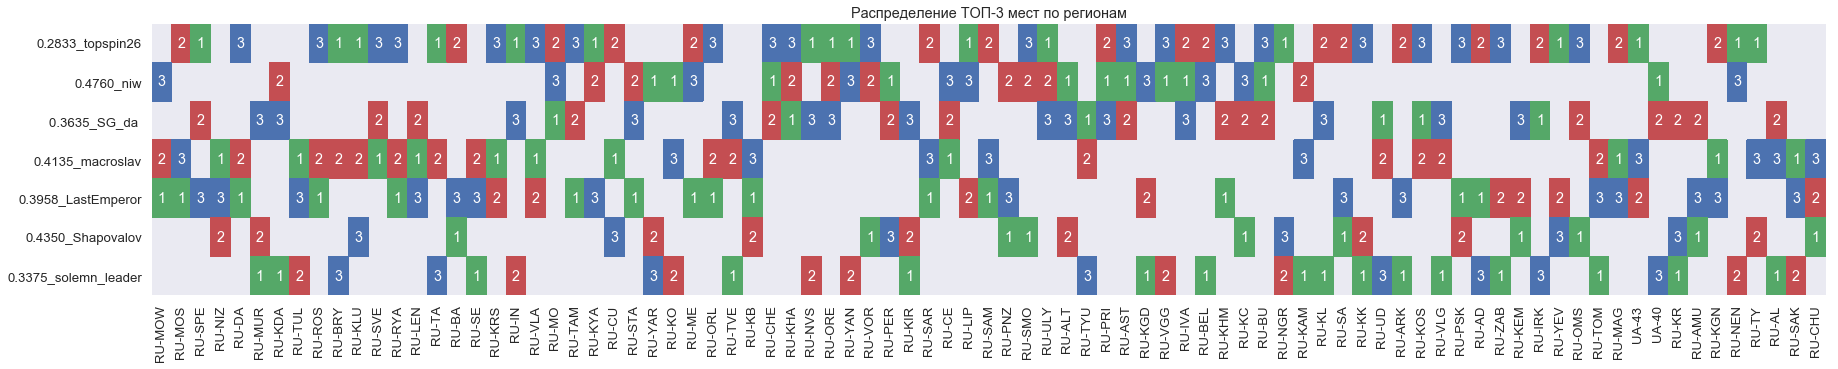

In [114]:
plt.figure(figsize=(30, 5))
sns.heatmap(places, yticklabels=['{:.4f}_{}'.format(np.sum(scores[e][1:]), e[:-4]) for e in subs_stage3], xticklabels=ru,
            cmap=[sns.color_palette()[2], sns.color_palette()[3], sns.color_palette()[0]], annot=True, cbar=False)
plt.title('Распределение ТОП-3 мест по регионам')
plt.show()